In [1]:
import numpy as np
import pandas as pd
import json
import scripts.scrape_gdpr_fines

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# scripts.scrape_gdpr_fines.scrape_fines()

In [3]:
with open('data/scraped_fines.json', 'r', encoding='utf-8') as f:
    all_fines = json.load(f)

In [4]:
ungrouped = all_fines['allItems']
fines = pd.json_normalize(ungrouped)

In [4]:
# text = pd.read_csv('data/gdpr_article_text.csv')

In [5]:
fines.head(3)

,id,picture,name,price,authority,date,controller,articleViolated,type,source,summary
0,1,https://www.privacyaffairs.com/wp-content/uplo...,Poland,9380,Polish National Personal Data Protection Offic...,10/18/2019,Polish Mayor,Art. 28 GDPR,Non-compliance with lawful basis for data proc...,https://uodo.gov.pl/decyzje/ZSPU.421.3.2019,No data processing agreement has been conclude...
1,2,https://www.privacyaffairs.com/wp-content/uplo...,Romania,2500,Romanian National Supervisory Authority for Pe...,10/17/2019,UTTIS INDUSTRIES,"Art. 12 GDPR, Art. 13 GDPR, Art. 5 (1) c) GDPR...",Information obligation non-compliance,https://www.dataprotection.ro/?page=A_patra_am...,A controller was sanctioned because he had unl...
2,3,https://www.privacyaffairs.com/wp-content/uplo...,Spain,60000,Spanish Data Protection Authority (AEPD),10/16/2019,Xfera Moviles S.A.,"Art. 5 GDPR, Art. 6 GDPR",Non-compliance with lawful basis for data proc...,https://www.aepd.es/resoluciones/PS-00262-2019...,The company had unlawfully processed the perso...


# How are the fines distributed?

In [6]:
fines_nozero = (
    fines
    .loc[fines.price > 0, :]
    .assign(date = lambda x: pd.to_datetime(x.date, format='%m/%d/%Y'))
)

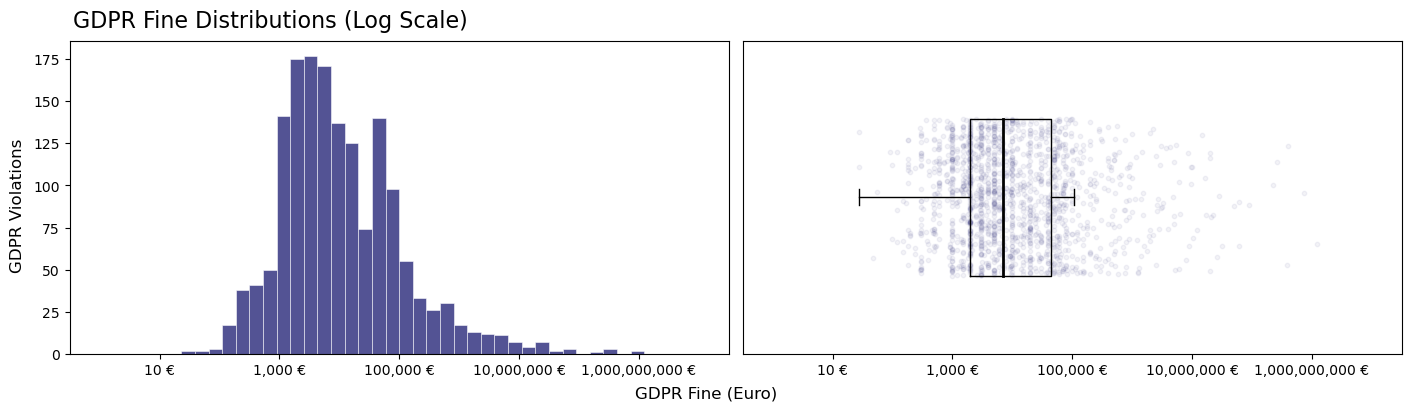

In [7]:
fig, ax = plt.subplots(1,2, figsize=(14, 4), sharex=True, layout="constrained")

# draw the figure to apply constrained_layout (useful only for positioning suptitle later)
fig.canvas.draw()

sns.histplot(
    fines_nozero, x="price",
    edgecolor="white", linewidth=.5, facecolor="midnightblue",
    log_scale=True, binrange=(0, 10),
    ax=ax[0]
)

for bar in ax[0].patches:
    bar.set_alpha(0.75) 

ax[0].set(xlabel= None, ylabel=None)
ax[0].xaxis.set_major_formatter('{x:,.0f} €')

# jitter points about 1 on y axis.
ax[1].scatter("price", "y", data=fines_nozero.assign(
    y=1+np.random.uniform(low=-0.25, high=0.25, size=len(fines_nozero))),
    c='midnightblue', alpha=0.05, s=10)

box = ax[1].boxplot(
    data=fines_nozero, x="price", vert=False,
    widths=0.5,
    showfliers=False,
    medianprops={'color':'black', 'linewidth':2}
)

# smaller caps
for cap in box['caps']:
    cap.set_ydata(cap.get_ydata() - [-0.1, 0.1])

ax[1].set_xscale('log')
ax[1].set(ylabel=None)
ax[1].set_yticks([])
ax[1].set_yticklabels([])
ax[1].xaxis.set_major_formatter('{x:,.0f} €')
fig.suptitle(
    t="GDPR Fine Distributions (Log Scale)", 
    x=ax[0].get_position(original=False).get_points()[0][0] + 0.0225,
    ha='left', fontsize=16,
)

fig.supylabel(t="GDPR Violations")
fig.supxlabel(t="GDPR Fine (Euro)");

# Questions

1. Who pays the most?
2. Who pays the most often? 
3. Which articles are the biggest culprits? 

13 is better to violate than 7, 12, 32, or 33. Can't really say about the others.

## Who pays the most?

In [9]:
def strfind(series, term):
    "shorthand"
    return series.str.contains(term, case=False)

fines_controller_gb = (
    fines_nozero
    .assign(
        shortname = lambda x: np.select(
            [strfind(x.controller, "Facebook"), strfind(x.controller, "Meta"), strfind(x.controller, "Amazon"), strfind(x.controller, "Google"),
             strfind(x.controller, "Microsoft"), strfind(x.controller, "Vodafone"), strfind(x.controller, "WhatsApp"),
             strfind(x.controller, "Clearview"), strfind(x.controller, "H&M"), strfind(x.controller, "Marriott")],
            ["Facebook/Meta", "Facebook/Meta", "Amazon", "Google", "Microsoft", "Vodafone", "WhatsApp", "Clearview AI", "H&M", "Marriot"],
            x.controller
        )
    )
    .assign(shortname = lambda x: x.shortname.str.title().str.strip())
    .groupby('shortname')
)

controller_counts = fines_controller_gb.size().to_frame(name='counts')
controller_stats = (
    controller_counts
    .join(fines_controller_gb.agg({'price':'sum'}).rename(columns={'price':'total_price'}))
    .join(fines_controller_gb.agg({'price':'mean'}).rename(columns={'price':'mean_price'}))
    .reset_index()
)

controller_stats.sort_values('counts', ascending=False).head(3)

,shortname,counts,total_price,mean_price
797,Private Individual,98,167250,1706.632653
1078,Vodafone,81,20236451,249832.728395
1044,Unknown,73,1952796,26750.630137


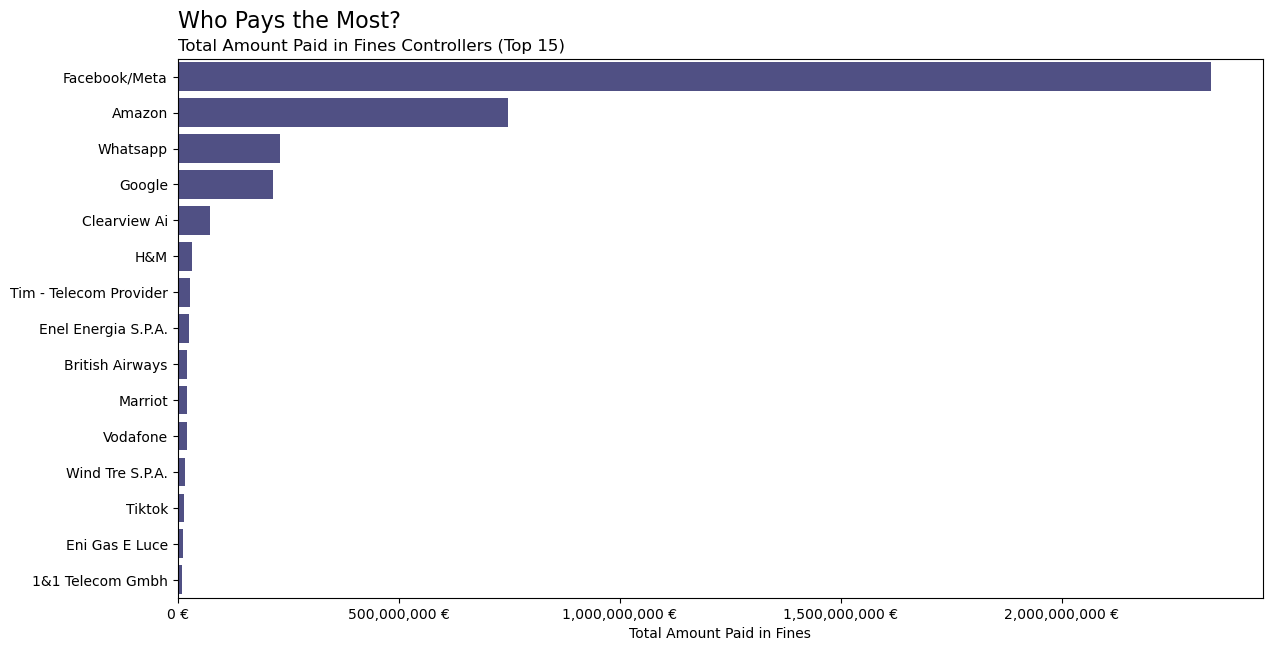

In [10]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.barplot(y='shortname', x='total_price', data=controller_stats.nlargest(15, columns='total_price'), color='midnightblue', ax=ax, orient='h', alpha=0.8)

ax.set(xlabel="Total Amount Paid in Fines", ylabel=None)
ax.xaxis.set_major_formatter('{x:,.0f} €')
ax.set_title(label="Total Amount Paid in Fines Controllers (Top 15)", loc="left", ha="left", size=12)
fig.suptitle(t="Who Pays the Most?", x=ax.get_position().get_points()[0][0], ha='left', fontsize=16, y=0.95);

## Who Pays the Most Often?

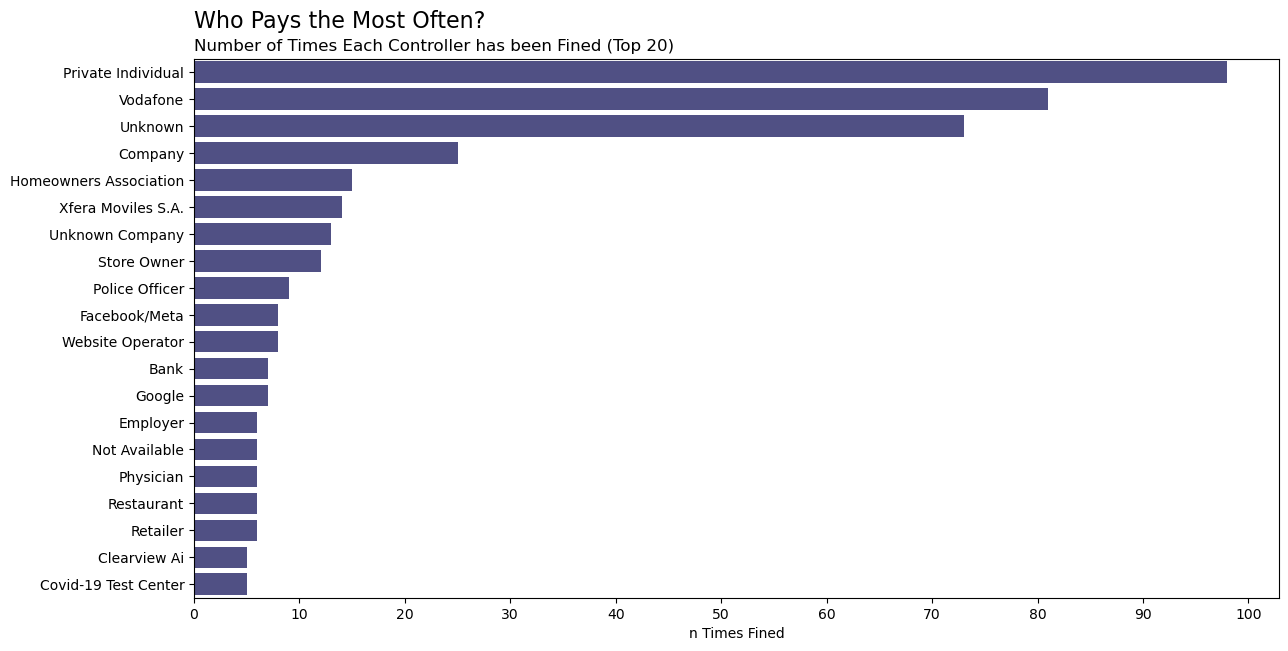

In [11]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.barplot(y='shortname', x='counts', data=controller_stats.nlargest(n=20, columns='counts'), color='midnightblue', ax=ax, orient='h', alpha=0.8)

ax.set(xlabel="n Times Fined", ylabel=None, xticks=range(0, controller_stats.counts.max()+10, 10))
ax.xaxis.set_major_formatter('{x:,.0f}')
ax.set_title(label="Number of Times Each Controller has been Fined (Top 20)", loc="left", ha="left", size=12)
fig.suptitle(t="Who Pays the Most Often?", x=ax.get_position().get_points()[0][0], ha='left', fontsize=16, y=0.95);

## How has the distribution of fines changed over time?

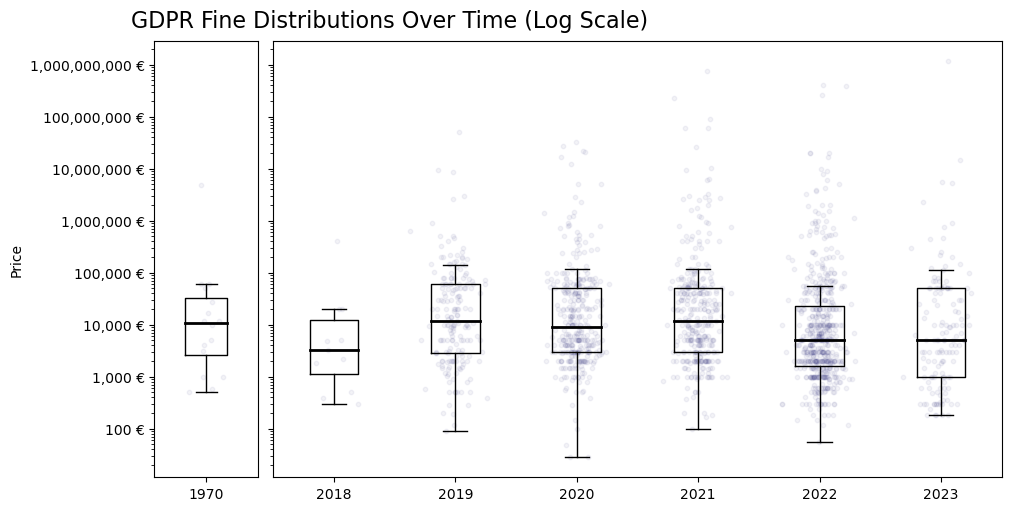

In [67]:
df = (fines_nozero.assign(
    year = lambda x: x.date.dt.year
))

# make data more friendly for matplotlib
prices_each_year = df.groupby('year')['price'].apply(lambda x: x.values)

# Get the years as labels
labels = list(prices_each_year.keys())
labels.sort()

#create a figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 7]},
 sharey=True, layout='constrained')

# Create a boxplot for the year 1970
ax[0].boxplot(prices_each_year[1970], labels=['1970'], widths=0.4, showfliers=False, medianprops={'color':'black', 'linewidth':2})
ax[0].set_ylabel('Price')


# Create a boxplot for the years other than 1970
years_other_than_1970 = [year for year in labels if year != 1970]
ax[1].boxplot([prices_each_year[year] for year in years_other_than_1970],
              labels=years_other_than_1970, showfliers=False, widths=0.4,
              medianprops={'color':'black', 'linewidth':2})
ax[1].set_ylabel(None)

jittered_x = np.random.normal(0 + 1, 0.1, len(prices_each_year[1970]))
ax[0].scatter(jittered_x, prices_each_year[1970], alpha=0.05, color='midnightblue', s=10)


# Overlay the data points for the years other than 1970
for i, year in enumerate(years_other_than_1970):
    jittered_x = np.random.normal(i + 1, 0.1, len(prices_each_year[year]))
    ax[1].scatter(jittered_x, prices_each_year[year], alpha=0.05, color='midnightblue', s=10)

ax[1].set_yscale('log')
ax[1].yaxis.set_major_formatter('{x:,.0f} €')
fig.suptitle(
    t="GDPR Fine Distributions Over Time (Log Scale)", 
    ha='left',
    x=ax[0].get_position().x0,
    fontsize=16,
    va='top'
)

plt.savefig('year_distribution.png')

0.125

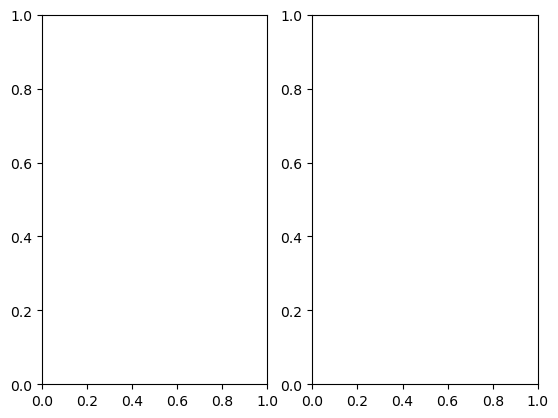

In [63]:
fig, ax = plt.subplots(1, 2)

ax[0].get_position().x0

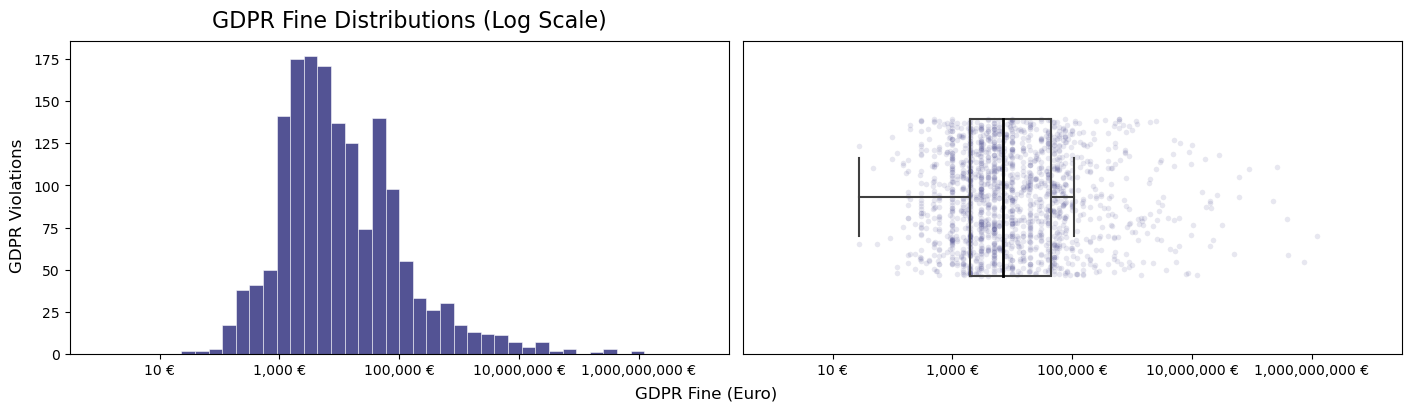

In [202]:
fig, ax = plt.subplots(1,2, figsize=(14, 4), sharex=True, layout="constrained")

sns.histplot(
    fines_nozero, x="price",
    edgecolor="white", linewidth=.5, facecolor="midnightblue",
    log_scale=True, binrange=(0, 10),
    ax=ax[0]
)

for bar in ax[0].patches:
    bar.set_alpha(0.75)
    
ax[0].set(xlabel= None, ylabel=None)
ax[0].xaxis.set_major_formatter('{x:,.0f} €')

sns.stripplot(
    x='price', data=fines_nozero,
    color='midnightblue',
    jitter=0.25,
    size=4,
    alpha=0.1,
    zorder=0,
    ax=ax[1]
)

sns.boxplot(
    data=fines_nozero, x="price",
    showfliers=False, width=0.5,
    boxprops={'facecolor':'none'},
    medianprops={"color": "black", "linewidth": 2},
    ax=ax[1]
)

ax[1].set_xscale('log')
ax[1].set(ylabel=None, xlabel=None)
ax[1].set_yticks([])
ax[1].set_yticklabels([])
ax[1].xaxis.set_major_formatter('{x:,.0f} €')
fig.suptitle(
    t="GDPR Fine Distributions (Log Scale)", 
    x=ax[0].get_position(original=False).get_points()[0][0] + 0.0225,
    ha='left', fontsize=16,
)

fig.supylabel(t="GDPR Violations")
fig.supxlabel(t="GDPR Fine (Euro)");

In [9]:
fines_long = (
    fines_nozero
    .articleViolated.str.extractall(r'([Aa]rt. \d+(?=.*GDPR))')
    .reset_index()
    .rename(columns={'level_0':'id', 0:'article'})
    .assign(
        n_articles_violated = lambda x: (
            x
            .groupby('id')
            .match.transform('max')
            .astype('Int64') + 1
        ),
        article_number = lambda x: (
            x
            .article.str.extract(r'(\d+)')
            .astype('float')
            .astype('Int64')
        )
    )
    .merge(fines_nozero, how='right', left_on='id', right_on='id')
    .assign(date = lambda x: pd.to_datetime(x.date, format='%m/%d/%Y'))
    .loc[:, ['id', 'name', 'price', 'authority', 'date', 'controller','article',
             'article_number', 'n_articles_violated', 'type', 'summary']]
    .rename(columns={'price':'total_fine_euro', 'name': 'country'})
)

In [10]:
fines_long

,id,country,total_fine_euro,authority,date,controller,article,article_number,n_articles_violated,type,summary
0,1,Poland,9380,Polish National Personal Data Protection Offic...,2019-10-18,Polish Mayor,Art. 12,12,4,Non-compliance with lawful basis for data proc...,No data processing agreement has been conclude...
1,1,Poland,9380,Polish National Personal Data Protection Offic...,2019-10-18,Polish Mayor,Art. 13,13,4,Non-compliance with lawful basis for data proc...,No data processing agreement has been conclude...
2,1,Poland,9380,Polish National Personal Data Protection Offic...,2019-10-18,Polish Mayor,Art. 5,5,4,Non-compliance with lawful basis for data proc...,No data processing agreement has been conclude...
3,1,Poland,9380,Polish National Personal Data Protection Offic...,2019-10-18,Polish Mayor,Art. 6,6,4,Non-compliance with lawful basis for data proc...,No data processing agreement has been conclude...
4,2,Romania,2500,Romanian National Supervisory Authority for Pe...,2019-10-17,UTTIS INDUSTRIES,Art. 5,5,2,Information obligation non-compliance,A controller was sanctioned because he had unl...
...,...,...,...,...,...,...,...,...,...,...,...
3240,1699,Malta,2500,Data Protection Commissioner of Malta,2020-01-01,Unknown,Art. 13,13,2,Failure to comply with data processing principles,The data controller had previously disclosed t...
3241,1699,Malta,2500,Data Protection Commissioner of Malta,2020-01-01,Unknown,Art. 15,15,2,Failure to comply with data processing principles,The data controller had previously disclosed t...
3242,1700,Malta,20000,Data Protection Commissioner of Malta,2020-01-01,Unknown,Art. 13,13,2,Non-compliance with subjects' rights protectio...,The data controller had previously failed to c...
3243,1700,Malta,20000,Data Protection Commissioner of Malta,2020-01-01,Unknown,Art. 15,15,2,Non-compliance with subjects' rights protectio...,The data controller had previously failed to c...


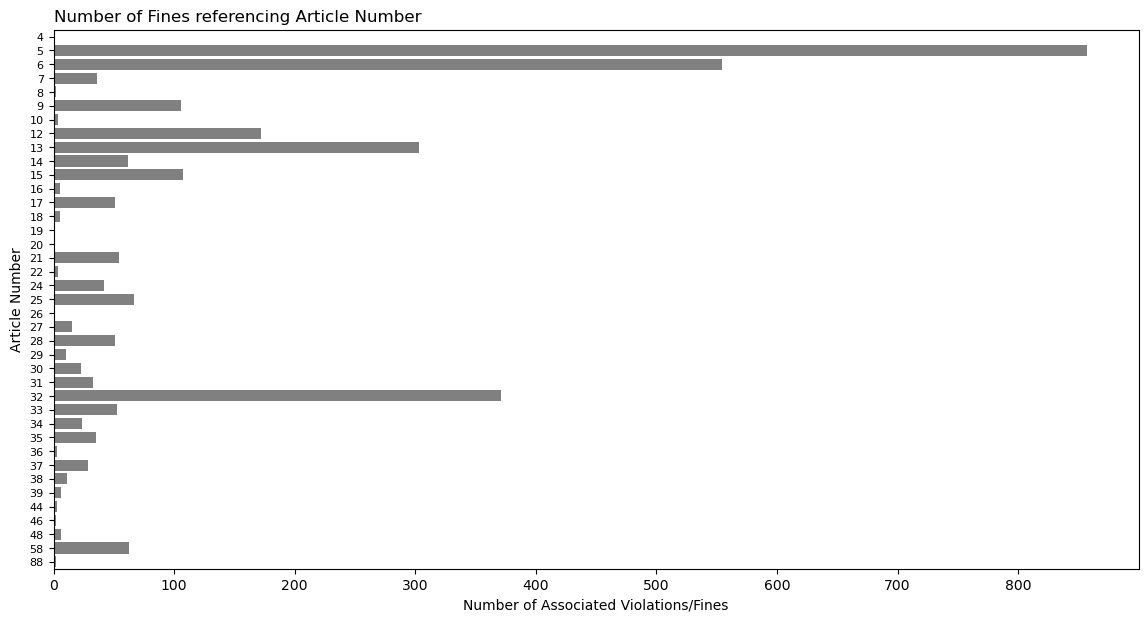

In [11]:
n_citations = (
    fines_long
    .value_counts('article_number')
    .reset_index(name='count')
    .sort_values('article_number')
)


fig, ax = plt.subplots(figsize = (14, 7))

sns.barplot(y='article_number', x='count', data=n_citations, orient='h', color='grey', ax=ax)
ax.tick_params(axis='y', which='major', labelsize=8)
ax.set_ylabel('Article Number')
ax.set_xlabel('Number of Associated Violations/Fines')
ax.set_title('Number of Fines referencing Article Number', loc='left');

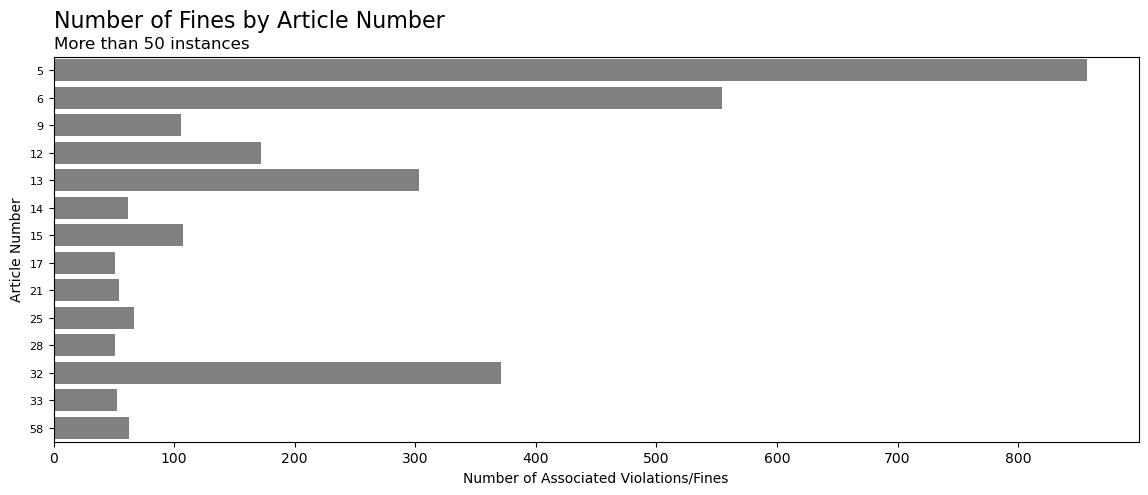

In [12]:
n_citations_min_n = n_citations.query('count > 50')

fig, ax = plt.subplots(figsize = (14, 5))

sns.barplot(y='article_number', x='count', data=n_citations_min_n, orient='h', color='grey', ax=ax)
ax.tick_params(axis='y', which='major', labelsize=8)
ax.set_ylabel('Article Number')
ax.set_xlabel('Number of Associated Violations/Fines')
# subtitle
ax.set_title('More than 50 instances', loc='left')
# figure title
fig.suptitle('Number of Fines by Article Number', x=ax.get_position().get_points()[0][0], ha='left', fontsize=16, y=0.975);

In [13]:
known_articles = (
    fines_long
    .sort_values('article_number')
    .dropna(subset='article_number')
)

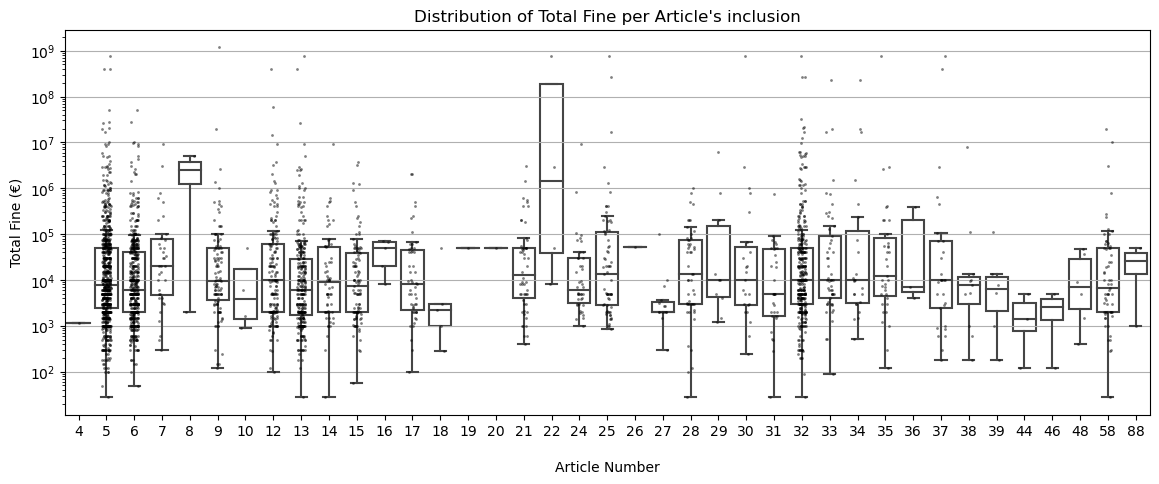

In [14]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.set_yscale("log")

sns.boxplot(
    x='article_number',
    y='total_fine_euro',
    data=known_articles,
    ax=ax,
    showfliers=False,
    boxprops={'facecolor':'white'}
)

sns.stripplot(
    x='article_number',
    y='total_fine_euro',
    data=known_articles,
    color='black',
    jitter=0.15,
    size=2,
    alpha=0.5,
    ax=ax
)

ax.yaxis.grid(True)
ax.set_title(label='', loc='left')
ax.set(xlabel="\nArticle Number", ylabel='Total Fine (€)', title='Distribution of Total Fine per Article\'s inclusion');

In [25]:
top_n_highest_fines = (
    known_articles
    .groupby('article_number')
    .agg({'total_fine_euro': 'sum'})
    .reset_index()
    .sort_values('total_fine_euro', ascending=False)
    .head(10)
)

only_top_n_highest_fines = (
    known_articles
    .loc[known_articles.article_number.isin(top_n_highest_fines.article_number.tolist())]
    .reset_index(drop=True)
)

In [15]:
MINUMUM_INCIDENCE = 30

overmin_incidence = (
    known_articles
    .loc[known_articles.article_number.isin(known_articles.value_counts('article_number').where(lambda x: x >= MINUMUM_INCIDENCE).dropna().index.to_list())]
)

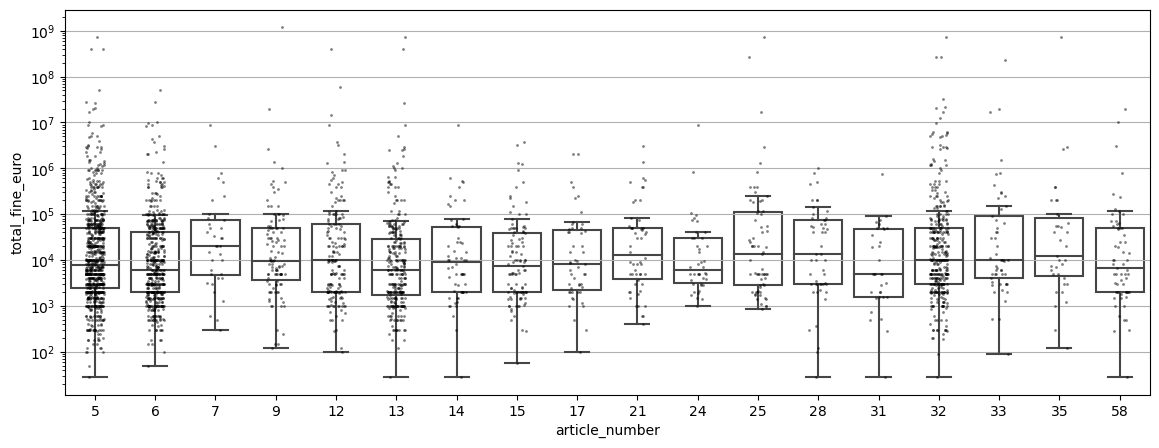

In [16]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.set_yscale("log")

sns.boxplot(
    x='article_number',
    y='total_fine_euro',
    data=overmin_incidence,
    ax=ax,
    showfliers=False,
    boxprops={'facecolor':'white'}
)

sns.stripplot(
    x='article_number',
    y='total_fine_euro',
    data=overmin_incidence,
    color='black',
    jitter=0.15,
    size=2,
    alpha=0.5,
    ax=ax
)

ax.yaxis.grid(True)

## Creating a Dataset for Modelling

In [17]:
# pivot data
gdpr_model_data = (
    overmin_incidence
    .assign(violated=1, year = lambda x: x.date.dt.year, total_fine_euro = lambda x: np.log10(x.total_fine_euro))
    .loc[:, ['id','year', 'country', 'total_fine_euro', 'article_number', 'violated']]
    .query('year > 2000')
    .pivot_table(values=['violated'], index=['id', 'year', 'country', 'total_fine_euro', 'article_number'])
    .unstack(level=-1, fill_value=0)
)

# sort out indexing
gdpr_model_data.columns = gdpr_model_data.columns.droplevel(0)
gdpr_model_data.columns.name = None

gdpr_model_data.columns = ['article_' + str(col) for col in gdpr_model_data.columns]

gdpr_model_data = gdpr_model_data.reset_index()

In [18]:
gdpr_model_data

,id,year,country,total_fine_euro,article_5,article_6,article_7,article_9,article_12,article_13,...,article_17,article_21,article_24,article_25,article_28,article_31,article_32,article_33,article_35,article_58
0,1,2019,Poland,3.972203,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,2019,Romania,3.397940,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2019,Spain,4.778151,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,2019,Spain,3.903090,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,5,2019,Romania,5.176091,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,1695,2022,Greece,7.301030,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1501,1697,2023,France,6.716003,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1502,1698,2020,Malta,3.301030,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1503,1699,2020,Malta,3.397940,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# Regressing Article on Total Fine Price

In [19]:
import statsmodels.api as sm

In [ ]:
# TODO:: include country in regression (just to see)

In [24]:
X = gdpr_model_data.drop(columns=["id", "total_fine_euro", "country", "year"])
y = gdpr_model_data.total_fine_euro

mod = sm.OLS(y, X.assign(constant=1))
res = mod.fit()

coefs = pd.concat([res.params, res.conf_int()], axis=1)

coefs.columns = ['estimate', 'ci0', 'ci1']

In [237]:
coefTable = (
    coefs
    .reset_index(names='coef')
    .assign(
        ci_length = lambda x: x.ci1 - x.estimate,
        hits0     = lambda x: (0 > x.ci0) & (0 < x.ci1),
        coef      = lambda x: x.coef.str.replace('article_', 'A')
    )
    .loc[lambda x: x.coef != 'constant', ['coef', 'estimate', 'ci_length', 'hits0']]
)

In [238]:
coefTable.head(2)

,coef,estimate,ci_length,hits0
0,A5,0.034799,0.109885,True
1,A6,-0.114058,0.120102,True


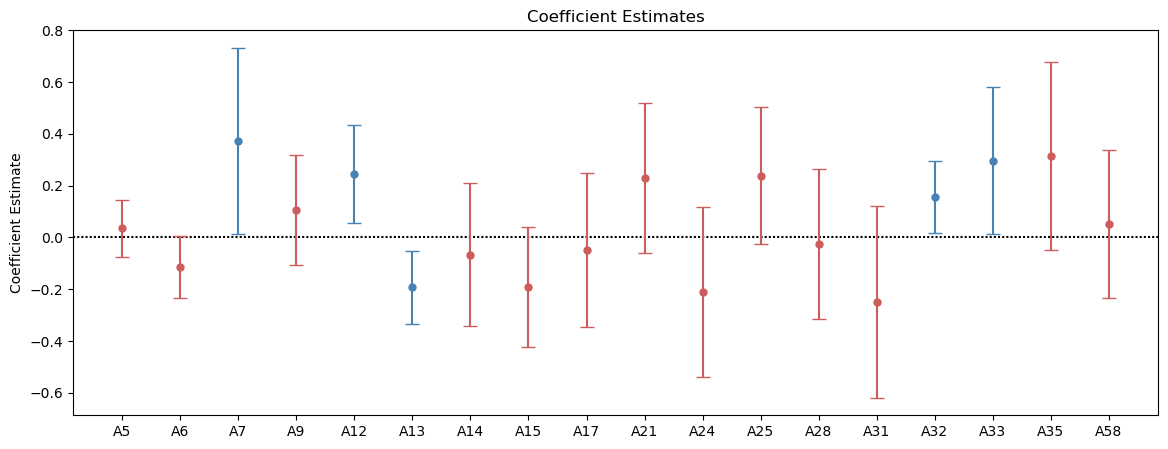

In [239]:
# ax = sns.pointplot(
#     x='coef', y='estimate',
#     data=coefs.reset_index(names='coef').query('coef != "constant"').assign(hits0 = lambda x: (0 > x.ci0) & (0 < x.ci1)),
#     join=False, markers="D",
#     hue='hits0')

# ax.errorbar(
#     coefs.estimate[:-1],
#     coefs.index[:-1],
#     xerr=ci_lengths[:-1],
#     fmt='o',
#     capsize=5
# )

colors = {'True': 'indianred', 'False': 'steelblue'}

fig, ax = plt.subplots(figsize=(14, 5))

ax.axhline(y=0, color="black", linestyle=(0, (1, 1)))
ax.set(xlabel=None, ylabel="Coefficient Estimate", title="Coefficient Estimates", xticks=coefTable.index, xticklabels=coefTable.coef)

for hit_type in np.unique(coefTable.hits0):
    color = colors[str(hit_type)]
    df_subset = coefTable.query(f'hits0 == {hit_type}')
    ax.errorbar(
        df_subset.index, df_subset.estimate, yerr=df_subset.ci_length,
        marker='o', color=color, ls='', ms=5, capsize=5, label=hit_type
    )

plt.show()

In [26]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        total_fine_euro   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2.823
Date:                Thu, 19 Oct 2023   Prob (F-statistic):           6.97e-05
Time:                        11:14:47   Log-Likelihood:                -2143.0
No. Observations:                1505   AIC:                             4324.
Df Residuals:                    1486   BIC:                             4425.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
article_5      0.0348      0.056      0.621      0.535      -0.075       0.145
article_6     -0.1141      0.061     -1.863      0.063      -0.234       0.006
article_7      0.3728      0.183      2.032      0.042       0.013       0.733
article_9      0.1071      0.108      0.992      0.321      -0.105       0.319
article_12     0.2447      0.097      2.534      0.011       0.055       0.434
article_13    -0.1930      0.072     -2.672      0.008      -0.335      -0.051
article_14    -0.0668      0.141     -0.474      0.635      -0.343       0.209
article_15    -0.1897      0.118     -1.607      0.108      -0.421       0.042
article_17    -0.0482      0.152     -0.317      0.752      -0.347       0.250
article_21     0.2291      0.148      1.553      0.121      -0.060       0.519
article_24    -0.2099      0.168     -1.252      0.211      -0.539       0.119
article_25     0.2391      0.135      1.777      0.076      -0.025       0.503
article_28    -0.0253      0.148     -0.172      0.864      -0.315       0.264
article_31    -0.2478      0.189     -1.310      0.191      -0.619       0.123
article_32     0.1570      0.071      2.201      0.028       0.017       0.297
article_33     0.2972      0.145      2.050      0.041       0.013       0.582
article_35     0.3146      0.186      1.694      0.090      -0.050       0.679
article_58     0.0513      0.146      0.353      0.724      -0.234       0.337
constant       4.0137      0.059     67.681      0.000       3.897       4.130
==============================================================================
Omnibus:                      233.541   Durbin-Watson:                   1.664
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              429.924
Skew:                           0.960   Prob(JB):                     4.40e-94
Kurtosis:                       4.781   Cond. No.                         9.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

1. Who pays the most?
2. Who pays the most often? 
3. Which articles are the biggest culprits? 

13 is better to violate than 7, 12, 32, or 33. Can't really say about the others.


In [14]:
# pivot data
gdpr_model_data = (
    only_top_n_highest_fines
    .assign(violated=1, year = lambda x: x.date.dt.year, total_fine_euro = lambda x: np.log10(x.total_fine_euro))
    .loc[:, ['id','year', 'country', 'total_fine_euro', 'article_number', 'violated']]
    .query('year > 2000')
    .pivot_table(values=['violated'], index=['id', 'year', 'country', 'total_fine_euro', 'article_number'])
    .unstack(level=-1, fill_value=0)
)

In [15]:
# sort out indexing
gdpr_model_data.columns = gdpr_model_data.columns.droplevel(0)
gdpr_model_data.columns.name = None

gdpr_model_data.columns = ['article_' + str(col) for col in gdpr_model_data.columns]

gdpr_model_data = gdpr_model_data.reset_index()

In [20]:
gdpr_model_data

,id,year,country,total_fine_euro,article_5,article_9,article_12,article_13,article_22,article_25,article_30,article_32,article_35,article_37
0,1,2019,Poland,3.972203,1,0,1,1,0,0,0,0,0,0
1,2,2019,Romania,3.397940,1,0,0,0,0,0,0,0,0,0
2,4,2019,Spain,3.903090,0,0,0,0,0,0,0,1,0,0
3,5,2019,Romania,5.176091,0,0,0,0,0,0,0,1,0,0
4,6,2019,Romania,4.301030,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1694,2022,Cyprus,3.176091,1,1,1,0,0,0,0,0,0,0
1196,1697,2023,France,6.716003,0,0,0,0,0,0,0,1,0,0
1197,1698,2020,Malta,3.301030,1,0,0,0,0,0,0,1,0,0
1198,1699,2020,Malta,3.397940,0,0,0,1,0,0,0,0,0,0


In [40]:
with_controller = (
    only_top_n_highest_fines
    .assign(violated=1, year = lambda x: x.date.dt.year)
    .loc[:, ['id', 'date', 'year', 'country', 'total_fine_euro', 'article_number', 'violated', 'controller']]
    .query('year > 2000')
    .pivot_table(values=['violated'], index=['id','date', 'year', 'country', 'total_fine_euro', 'article_number', 'controller'])
    .unstack(level=-2, fill_value=0)
)

# sort out indexing
with_controller.columns = with_controller.columns.droplevel(0)
with_controller.columns.name = None

with_controller.columns = ['article_' + str(col) for col in with_controller.columns]

with_controller = with_controller.reset_index()

NameError: name 'only_top_n_highest_fines' is not defined

In [20]:
top5_fines_per_yer = (
    with_controller
    .loc[with_controller.groupby('year')['total_fine_euro'].nlargest(5).reset_index().level_1]
    .copy()
)

In [21]:
highbois = (
    top5_fines_per_yer
    .loc[top5_fines_per_yer.total_fine_euro > 2e8, ['country', 'controller', 'date', 'total_fine_euro']]
    .copy()
)

In [22]:
def strfind(term):
    "shorthand"
    return highbois.controller.str.contains(term)

highbois = highbois.assign(
    shortname = np.select(
        [strfind("Meta"), strfind("Amazon"), strfind("Google"), strfind("Microsoft"), strfind("Vodafone")],
        ["Meta", "Amazon", "Google", "Microsoft", "Vodafone"]
    )
)

NameError: name 'with_controller' is not defined

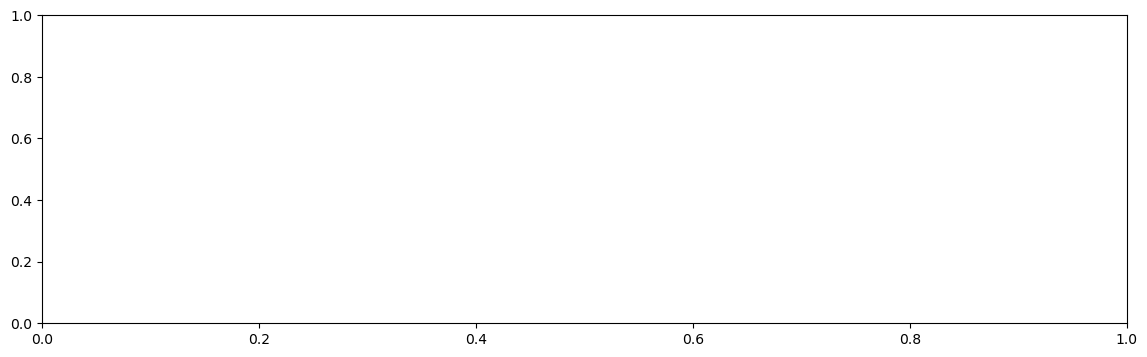

In [39]:
fig, ax = plt.subplots(1, figsize=(14, 4))

sns.scatterplot(x='date', y='total_fine_euro', data=with_controller)
# sns.lineplot(x='date', y='total_fine_euro', data=with_controller)

for _, boi in highbois.iterrows():
    xy = (boi.date, boi.total_fine_euro)
    text = boi.shortname + '\n' + boi.country
    ax.annotate(text=text,
            xy=xy, xycoords='data',
            xytext=(-10, -10), textcoords='offset points',
            ha='right',
            fontsize='medium'
    )

ax.set(title=None, xlabel=None, ylabel ="Total Fine")
ax.set_yscale("log")
ax.yaxis.set_major_formatter('{x:,.0f} €')

## Fine Value Distribution Plots

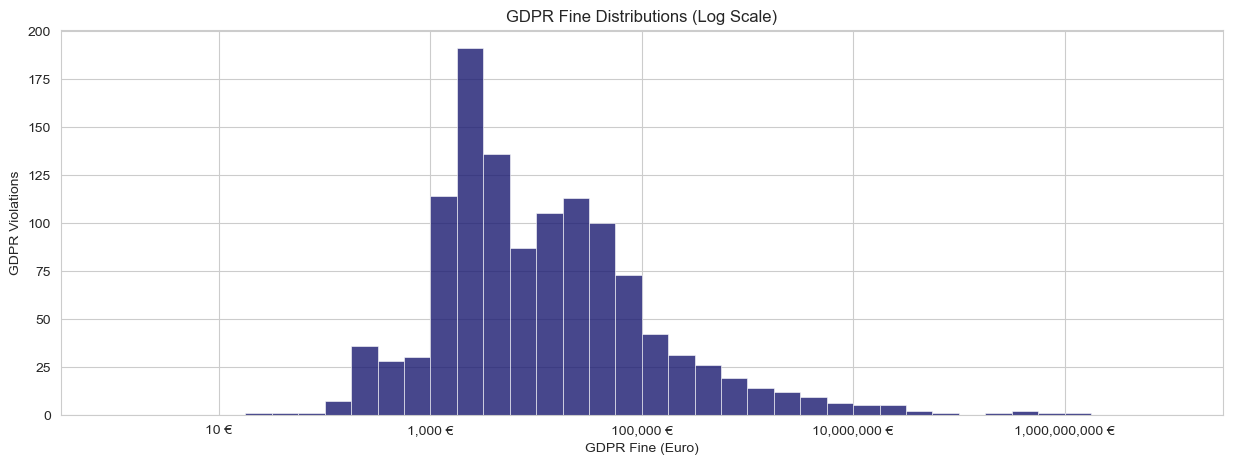

In [232]:
fig, ax = plt.subplots(figsize=(15, 5))

ax = sns.histplot(
    with_controller,
    x="total_fine_euro",
    edgecolor="white",
    linewidth=.5,
    facecolor="midnightblue",
    log_scale=True,
    binrange=(0, 10)
)


for bar in ax.patches:
    bar.set_alpha(0.8) 

ax.set(xlabel="GDPR Fine (Euro)", ylabel="GDPR Violations", title="GDPR Fine Distributions (Log Scale)")
ax.xaxis.set_major_formatter('{x:,.0f} €');

Text(0.5, 0, '')

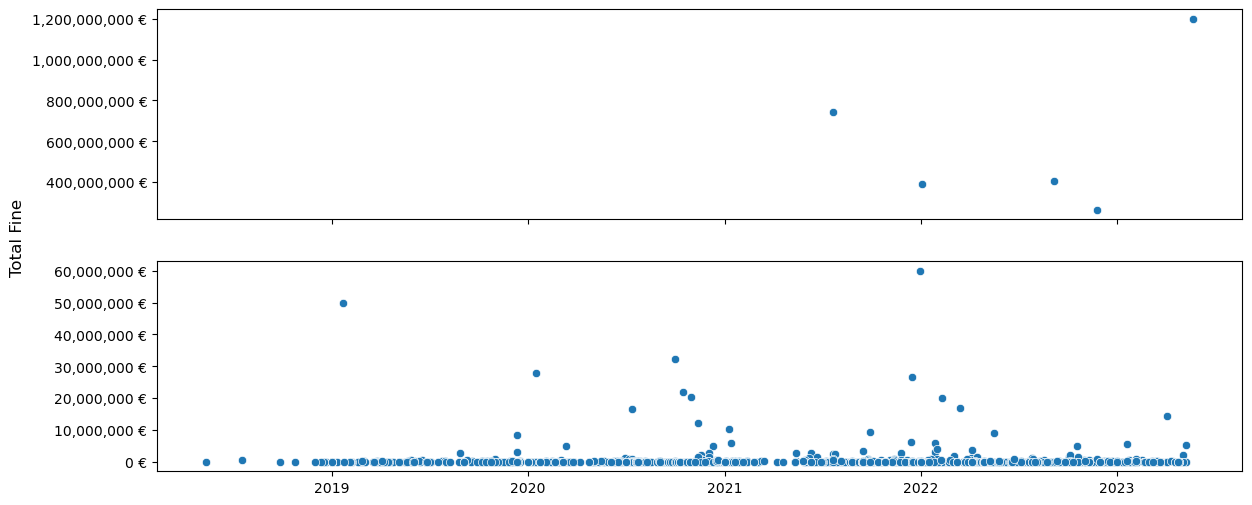

In [124]:
fig, ax = plt.subplots(2, figsize=(14, 6), sharex=True, sharey=False)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('total_fine_euro > 2e8'),
    ax=ax[0]
)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('total_fine_euro <= 2e8'),
    ax=ax[1]
)

for axis in ax:
    axis.yaxis.set_major_formatter('{x:,.0f} €')
    axis.set_ylabel(None)
fig.supylabel('Total Fine')
plt.xlabel(None)

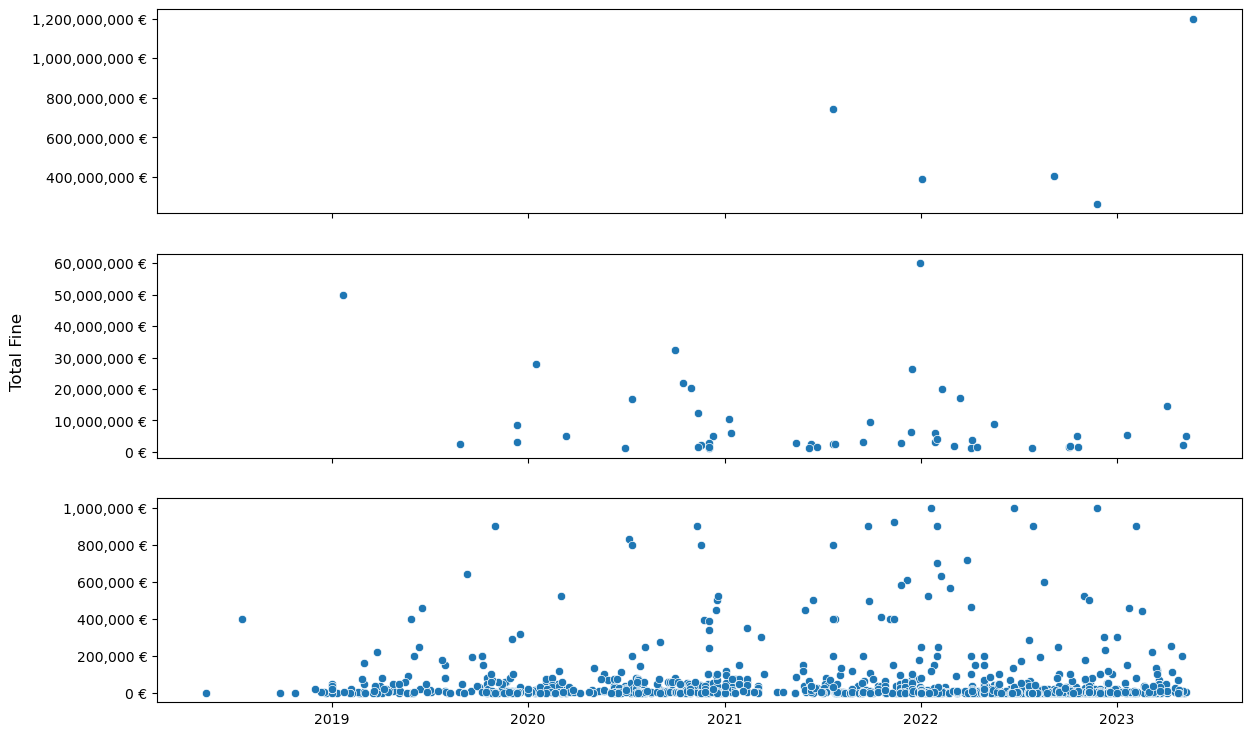

In [126]:
fig, ax = plt.subplots(3, figsize=(14, 9), sharex=True, sharey=False)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('total_fine_euro > 2e8'),
    ax=ax[0]
)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('1e6 < total_fine_euro <= 2e8'),
    ax=ax[1]
)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('total_fine_euro <= 1e6'),
    ax=ax[2]
)

for axis in ax:
    axis.yaxis.set_major_formatter('{x:,.0f} €')
    axis.set_ylabel(None)
    
fig.supylabel('Total Fine')
plt.xlabel(None);

## Individual Controllers

In [53]:
def strfind(series, term):
    "shorthand"
    return series.str.contains(term, case=False)

(
    with_controller
    .query('total_fine_euro > 1e6')
    .sort_values('date')
    .assign(
        shortname = lambda x: np.select(
            [strfind(x.controller, "Facebook"), strfind(x.controller, "Meta"), strfind(x.controller, "Amazon"), strfind(x.controller, "Google"),
             strfind(x.controller, "Microsoft"), strfind(x.controller, "Vodafone"), strfind(x.controller, "WhatsApp"),
             strfind(x.controller, "Clearview")],
            ["Facebook/Meta", "Facebook/Meta", "Amazon", "Google", "Microsoft", "Vodafone", "WhatsApp", "Clearview AI"],
            x.controller
        )
    )
    .groupby('shortname')
    .total_fine_euro
    .sum()
    .reset_index()
    .sort_values('total_fine_euro', ascending=False)
)


,shortname,total_fine_euro
23,Facebook/Meta,2337000000
3,Amazon,746000000
25,Google,55000000
12,Clearview AI,34200000
27,H&M Hennes & Mauritz Online Shop A.B. & Co. KG,32258708
37,TIM - Telecom Provider,27800000
21,Enel Energia S.p.A.,26500000
8,British Airways,22046000
30,"Marriott International, Inc",20450000
43,Wind Tre S.p.A.,16700000


In [158]:
top_25_fined_controllers = (
    fines_long
    .groupby('controller')
    .agg({'total_fine_euro':['sum', 'count', 'mean']})
    .droplevel(0, axis='columns')
    .reset_index()
    .sort_values('sum', ascending=False)
    .head(25)
)

## Single Violation Exploration

In [84]:
single_violations = (
    with_controller
    .assign(
        n_articles_violated = lambda x: x.loc[:, x.columns.str.startswith('article')].sum(axis='columns')
    )
    .query('n_articles_violated == 1')
    .melt(
        id_vars=['id', 'date', 'year', 'country', 'total_fine_euro', 'controller', 'n_articles_violated'],
        value_vars = with_controller.columns[with_controller.columns.str.startswith('article')].tolist(),
        var_name='article_violated',
        value_name='violated'
    )
    .loc[lambda x: x.violated == 1, ['id', 'date', 'year', 'country', 'total_fine_euro', 'article_violated']]
)

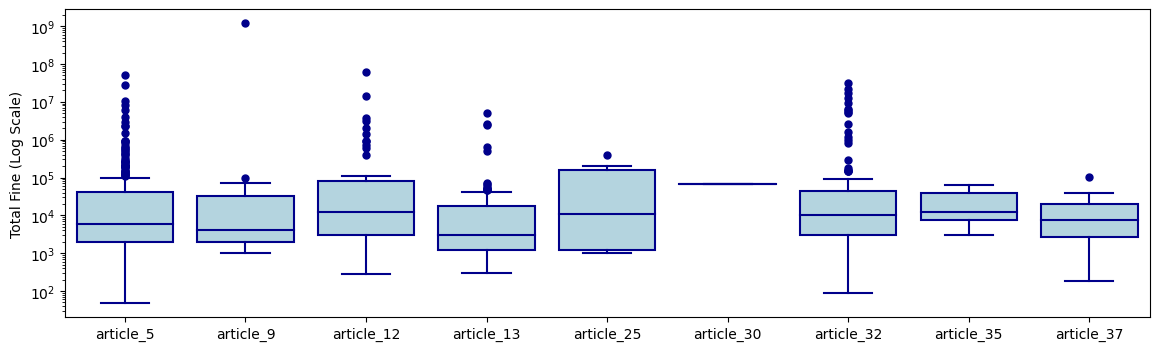

In [128]:
fig, ax = plt.subplots(1, figsize=(14,4))

sns.boxplot(
    y='total_fine_euro',
    x='article_violated',
    data=single_violations,
    ax=ax, color='lightblue',
    whiskerprops={'color':'darkblue'},
    boxprops={'edgecolor':'darkblue'},
    capprops={'color':'darkblue'},
    medianprops={'color':'darkblue'},
    flierprops={
        "marker": "o",
        "markerfacecolor':'darkblue",
                'markeredgecolor':'darkblue'
    })

ax.set(xlabel=None, ylabel="Total Fine (Log Scale)")
ax.set_yscale("log")

## Modelling

```r
library(tidymodels)

gdpr_rec <- recipe(price ~ ., data = gdpr_violations) %>%
  update_role(id, new_role = "id") %>%
  step_log(price, base = 10, offset = 1, skip = TRUE) %>%
  step_other(country, other = "Other") %>%
  step_dummy(all_nominal()) %>%
  step_zv(all_predictors())

gdpr_prep <- prep(gdpr_rec)

gdpr_prep

```

In [237]:
from sklearn.linear_model import LinearRegression

In [244]:
gdpr_model_data

,id,year,country,total_fine_euro,article_5,article_9,article_12,article_13,article_22,article_25,article_30,article_32,article_35,article_37
0,1,2019,Poland,3.972203,1,0,1,1,0,0,0,0,0,0
1,2,2019,Romania,3.397940,1,0,0,0,0,0,0,0,0,0
2,4,2019,Spain,3.903090,0,0,0,0,0,0,0,1,0,0
3,5,2019,Romania,5.176091,0,0,0,0,0,0,0,1,0,0
4,6,2019,Romania,4.301030,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1694,2022,Cyprus,3.176091,1,1,1,0,0,0,0,0,0,0
1196,1697,2023,France,6.716003,0,0,0,0,0,0,0,1,0,0
1197,1698,2020,Malta,3.301030,1,0,0,0,0,0,0,1,0,0
1198,1699,2020,Malta,3.397940,0,0,0,1,0,0,0,0,0,0


In [252]:
X = gdpr_model_data.drop(columns=["id", "total_fine_euro", "country"])
y = gdpr_model_data.total_fine_euro

In [260]:
model = LinearRegression(fit_intercept=True)
fit = model.fit(X, y)

In [321]:
coefs = pd.DataFrame(
    {"intercept" : fit.intercept_} |dict(zip(fit.feature_names_in_, fit.coef_)), index=pd.RangeIndex(start=0, stop=1)
).transpose().reset_index()

In [365]:
import statsmodels.api as sm

,year,article_5,article_9,article_12,article_13,article_22,article_25,article_30,article_32,article_35,article_37
0,2019,1,0,1,1,0,0,0,0,0,0
1,2019,1,0,0,0,0,0,0,0,0,0
2,2019,0,0,0,0,0,0,0,1,0,0
3,2019,0,0,0,0,0,0,0,1,0,0
4,2019,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1195,2022,1,1,1,0,0,0,0,0,0,0
1196,2023,0,0,0,0,0,0,0,1,0,0
1197,2020,1,0,0,0,0,0,0,1,0,0
1198,2020,0,0,0,1,0,0,0,0,0,0


In [421]:
mod = sm.OLS(y, X.assign(constant=1))
res = mod.fit()

coefs = pd.concat([res.params, res.conf_int()], axis=1)

coefs.columns = ['estimate', 'ci0', 'ci1']

coefs.reset_index(names='coef').query('coef != "constant"')

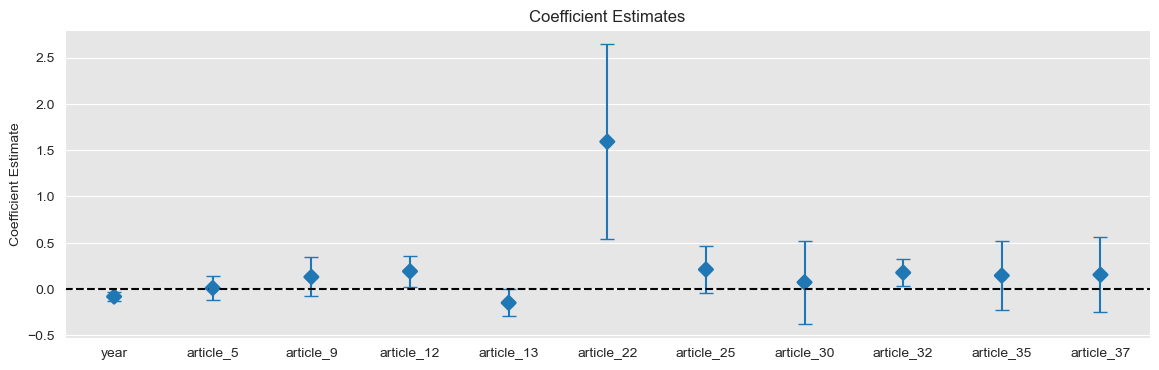

In [472]:
ci_lengths = coefs.ci1 - coefs.estimate

fig, ax = plt.subplots(figsize = (14, 4))

ax = sns.pointplot(
    x='coef', y='estimate',
    data=coefs.reset_index(names='coef').query('coef != "constant"'),
    join=False, markers="D")

ax.errorbar(
    coefs.index[:-1],
    coefs.estimate[:-1],
    yerr=ci_lengths[:-1],
    fmt='o',
    capsize=5
)

ax.axhline(y=0, color="black", linestyle="--")
ax.set(xlabel=None, ylabel="Coefficient Estimate", title="Coefficient Estimates");